In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path to the Drive directory
drive_path = "/content/drive/MyDrive"

Mounted at /content/drive


In [3]:
# Define the dataset path
dataset_path = os.path.join(drive_path, "dataset_code_language.csv")

# Read the dataset into a DataFrame
data = pd.read_csv(dataset_path)

# Handle missing values and remove duplicates
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

# Print random examples
print(data.sample(n=15))

                                                    code    language
1627   # For advice on how to change settings please ...        bash
1670   #!/bin/bash\nadv=17; \nwhile [[ $adv -lt 48 ]]...        bash
13731  U.S. skier River Radamus posted an emotional m...   plaintext
5682   ﻿<html><head><meta http-equiv="X-UA-Compatible...        html
8855   function setup(){\n  createCanvas(windowWidth,...  javascript
12472  <?php\n/*\n * Created on 2012-6-30\n *\n * To ...         php
14987  Low-income California residents could see unpa...   plaintext
1142   #!/bin/bash\necho "docker run -e DOTNETCORE_EN...        bash
164    #!/bin/bash\n\n# CI entry point\n# automatical...        bash
12673  Jerry Allison (top), drummer for rock legend B...   plaintext
13816  Signet A set of the beautiful press-on nails a...   plaintext
10665  <?php\n\n/* AdminBundle:Technique:addPlanifica...         php
2713   /*!\n * \n *    jodit - Jodit is awesome and u...         css
11159  <?php\n\n// Only load scrip

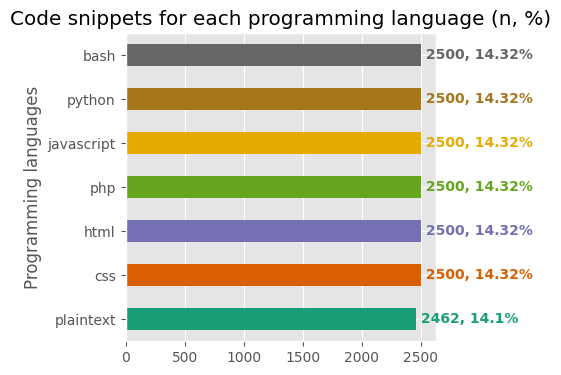

In [5]:
# Define your custom order and reverse it for correct display
order = ['bash', 'python', 'javascript', 'php', 'html', 'css', 'plaintext'][::-1]

# Count the values and sort by the custom order
counts = data["language"].value_counts()
counts = counts.loc[order]

plt.style.use("ggplot")
num_classes = len(counts)
colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

counts.plot.barh(title="Code snippets for each programming language (n, %)", 
                 ylabel="Programming languages",
                 color=colors,
                 figsize=(4,4))

for i, v in enumerate(counts):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/data.shape[0],2))+"%", 
           color=c, 
           va="center", 
           fontweight="bold")

plt.show()

In [6]:
# Train/Test split
X, y = data.code, data.language
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# Model params
# This regex pattern is used by the TfidfVectorizer to tokenize the text.
# It matches words, special characters, and spaces/tabs/newlines.
token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""" 

# Preprocessing function
# This function preprocesses the input data by removing certain patterns.
def preprocess(x):
    """Preprocesses the input data by removing certain patterns."""
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

In [8]:
import multiprocessing

# Get number of available CPUs
# This will be used for parallelizing the computation.
num_cores = multiprocessing.cpu_count()
print(f'Number of available CPUs: {num_cores}')

Number of available CPUs: 40


In [9]:
import pickle

# Define the best_params path
best_params_path = os.path.join(drive_path, "best_params.pkl")

# Load the best parameters
with open(best_params_path, 'rb') as f:
    best_params = pickle.load(f)

print(f'Best parameters: {best_params}')

Best parameters: {'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__min_samples_split': 4, 'clf__n_estimators': 300}


In [10]:
# Define the steps of the pipeline
transformer = FunctionTransformer(preprocess)
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

# Correct the parameter names by removing the 'clf__' prefix
corrected_best_params = {key.replace('clf__', ''): value for key, value in best_params.items()}

# Now use corrected_best_params to initialize the model
clf = RandomForestClassifier(n_jobs=-1, **corrected_best_params)  # Use all available cores
pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('clf', clf)]
)

In [11]:
# Fitting the model
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocess at 0x7f021d0eeb00>)),
                ('vectorizer',
                 TfidfVectorizer(max_features=3000,
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\t\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('clf',
                 RandomForestClassifier(min_samples_split=4, n_estimators=300,
                                        n_jobs=-1))])

In [12]:
# Evaluation
print(f'Test set accuracy: {pipe_RF.score(X_test, y_test)}')

Test set accuracy: 0.9876896650443745


In [13]:
# Classification report
# This report displays the precision, recall, f1-score and support of the model.
y_pred = pipe_RF.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bash       0.98      0.99      0.99       469
         css       0.99      0.99      0.99       508
        html       0.98      0.98      0.98       524
  javascript       0.98      0.98      0.98       496
         php       0.99      0.98      0.99       516
   plaintext       1.00      1.00      1.00       477
      python       1.00      0.98      0.99       503

    accuracy                           0.99      3493
   macro avg       0.99      0.99      0.99      3493
weighted avg       0.99      0.99      0.99      3493



In [14]:
# Convert predictions to a pandas Series for easier comparison
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Create a DataFrame with text, true labels and predicted labels
df_results = pd.DataFrame({
    'text': X_test,
    'true': y_test,
    'predicted': y_pred_series
})

# Filter for rows where the true label doesn't match the predicted label
misclassified = df_results[df_results.true != df_results.predicted]

# Select five random misclassified examples
random_misclassified = misclassified.sample(n=5)

# Print each of these in a pretty format
for idx, row in random_misclassified.iterrows():
    print(f'Example {idx}:\n\n{row["text"]}\n\nTrue Label: {row["true"]}\nPredicted Label: {row["predicted"]}\n{"-"*50}\n')

Example 11679:

<!DOCTYPE html>

<html>

<head>
    <title>Forget passwrod</title>

    <meta name="viewport" content="width=device-width">

    <link href="css/bootstrap.css" rel="stylesheet">
    <link href="css/main.css" rel="stylesheet">

    <link href='https://fonts.googleapis.com/css?family=Open+Sans:400,300,600,700,800' rel='stylesheet' type='text/css'>
    <link href="images/logo-icon.png" rel="icon">

    <script src="../js/jquery-1.12.1.min.js"></script>
    <script src="../js/bootstrap.js"></script>
</head>

<body><br><br><br><br><br><br><br><br><br><br><br><br><br>
    <div>
        <!-- Forget passowrd starts -->
        <div class="floating-card col-md-6 col-md-offset-3 col-xs-10 col-xs-offset-1" id="forget-password">
            <h2 class="text-center">Error</h2>

            <div class="input-layout">
                <?=$data['msg']?>
                <br>click <a href="?url=home/index">here</a> to go to home page.
            </div>

        </div>
    </div>
</body>
<

In [42]:
def predict_language(snippet):
    """Predict the programming language of a given code snippet."""
    # Use the pipeline to predict the language
    prediction = pipe_RF.predict([snippet])
    # Return the predicted language
    return prediction[0]

In [43]:
def predict_language(snippet):
    """Predict the second most likely programming language of a given code snippet."""
    # Use the pipeline to predict the probabilities for each language
    probabilities = pipe_RF.predict_proba([snippet])
    
    # Get the indices of classes in descending order of probability
    class_indices = np.argsort(probabilities, axis=1)[0][::-1]
    
    # Get the second most probable class index
    second_most_probable_index = class_indices[1]

    # Get the class names
    class_names = pipe_RF.classes_

    # Return the second most probable language
    return class_names[second_most_probable_index]

In [44]:
# Making predictions on unseen data
unseen_data = """
>>> r = requests.get('http://chall.csivit.com:30202?file=checkpass.php', allow_redirects=False)
>>> r.text
'IMPORTANT!!! The page is still under development. This has a secret, do not push this page.'
"""
prediction = predict_language(unseen_data)
print(prediction)

php


In [45]:
# Making predictions on unseen data
unseen_data = """
/?file=php://filter/convert.base64-encode/resource=checkpass.php

PD9waHAKJHBhc3N3b3JkID0gIncwcmRjMHVudDEyMyI7Ci8vIENvb2tpZSBwYXNzd29yZC4KZWNobyAiSU1QT1JUQU5UISEhIFRoZSBwYWdlIGlzIHN0aWxsIHVuZGVyIGRldmVsb3BtZW50LiBUaGlzIGhhcyBhIHNlY3JldCwgZG8gbm90IHB1c2ggdGhpcyBwYWdlLiI7CgpoZWFkZXIoJ0xvY2F0aW9uOiAvJyk7Cg==
"""
prediction = predict_language(unseen_data)
print(prediction)

php


In [46]:
# Making predictions on unseen data
unseen_data = """
$ echo "PD9waHAKJHBhc3N3b3JkID0gIncwcmRjMHVudDEyMyI7Ci8vIENvb2tpZSBwYXNzd29yZC4KZWNobyAiSU1QT1JUQU5UISEhIFRoZSBwYWdlIGlzIHN0aWxsIHVuZGVyIGRldmVsb3BtZW50LiBUaGlzIGhhcyBhIHNlY3JldCwgZG8gbm90IHB1c2ggdGhpcyBwYWdlLiI7CgpoZWFkZXIoJ0xvY2F0aW9uOiAvJyk7Cg==" | base64 -d
<?php
$password = "w0rdc0unt123";
// Cookie password.
echo "IMPORTANT!!! The page is still under development. This has a secret, do not push this page.";

header('Location: /');
"""
prediction = predict_language(unseen_data)
print(prediction)

bash


In [47]:
# Making predictions on unseen data
unseen_data = """
$ echo "PCFET0NUWVBFIGh0bWw+CjxodG1sIGxhbmc9ImVuIj4KCjxoZWFkPgogICAgPG1ldGEgY2hhcnNldD0iVVRGLTgiPgogICAgPG1ldGEgbmFtZT0idmlld3BvcnQiIGNvbnRlbnQ9IndpZHRoPWRldmljZS13aWR0aCwgaW5pdGlhbC1zY2FsZT0xLjAiPgogICAgPG1ldGEgaHR0cC1lcXVpdj0iWC1VQS1Db21wYXRpYmxlIiBjb250ZW50PSJpZT1lZGdlIj4KICAgIDx0aXRsZT53YyBhcyBhIHNlcnZpY2U8L3RpdGxlPgogICAgPHN0eWxlPgogICAgICAgIGh0bWwsCiAgICAgICAgYm9keSB7CiAgICAgICAgICAgIG92ZXJmbG93OiBub25lOwogICAgICAgICAgICBtYXgtaGVpZ2h0OiAxMDB2aDsKICAgICAgICB9CiAgICA8L3N0eWxlPgo8L2hlYWQ+Cgo8Ym9keSBzdHlsZT0iaGVpZ2h0OiAxMDB2aDsgdGV4dC1hbGlnbjogY2VudGVyOyBiYWNrZ3JvdW5kLWNvbG9yOiBibGFjazsgY29sb3I6IHdoaXRlOyBkaXNwbGF5OiBmbGV4OyBmbGV4LWRpcmVjdGlvbjogY29sdW1uOyBqdXN0aWZ5LWNvbnRlbnQ6IGNlbnRlcjsiPgogICAgPD9waHAKICAgIGluaV9zZXQoJ21heF9leGVjdXRpb25fdGltZScsIDUpOwogICAgaWYgKCRfQ09PS0lFWydwYXNzd29yZCddICE9PSBnZXRlbnYoJ1BBU1NXT1JEJykpIHsKICAgICAgICBzZXRjb29raWUoJ3Bhc3N3b3JkJywgJ1BBU1NXT1JEJyk7CiAgICAgICAgZGllKCdTb3JyeSwgb25seSBwZW9wbGUgZnJvbSBjc2l2aXQgYXJlIGFsbG93ZWQgdG8gYWNjZXNzIHRoaXMgcGFnZS4nKTsKICAgIH0KICAgID8+CgogICAgPGgxPkNoYXJhY3RlciBDb3VudCBhcyBhIFNlcnZpY2U8L2gxPgogICAgPGZvcm0+CiAgICAgICAgPGlucHV0IHR5cGU9ImhpZGRlbiIgdmFsdWU9IndjLnBocCIgbmFtZT0iZmlsZSI+CiAgICAgICAgPHRleHRhcmVhIHN0eWxlPSJib3JkZXItcmFkaXVzOiAxcmVtOyIgdHlwZT0idGV4dCIgbmFtZT0idGV4dCIgcm93cz0zMCBjb2xzPTEwMD48L3RleHRhcmVhPjxiciAvPgogICAgICAgIDxpbnB1dCB0eXBlPSJzdWJtaXQiPgogICAgPC9mb3JtPgogICAgPD9waHAKICAgIGlmIChpc3NldCgkX0dFVFsidGV4dCJdKSkgewogICAgICAgICR0ZXh0ID0gJF9HRVRbInRleHQiXTsKICAgICAgICBlY2hvICI8aDI+VGhlIENoYXJhY3RlciBDb3VudCBpczogIiAuIGV4ZWMoJ3ByaW50ZiBcJycgLiAkdGV4dCAuICdcJyB8IHdjIC1jJykgLiAiPC9oMj4iOwogICAgfQogICAgPz4KPC9ib2R5PgoKPC9odG1sPg==" | base64 -d
<!DOCTYPE html>
<html lang="en">

<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="ie=edge">
    <title>wc as a service</title>
    <style>
        html,
        body {
            overflow: none;
            max-height: 100vh;
        }
    </style>
</head>

<body style="height: 100vh; text-align: center; background-color: black; color: white; display: flex; flex-direction: column; justify-content: center;">
    <?php
    ini_set('max_execution_time', 5);
    if ($_COOKIE['password'] !== getenv('PASSWORD')) {
        setcookie('password', 'PASSWORD');
        die('Sorry, only people from csivit are allowed to access this page.');
    }
    ?>

    <h1>Character Count as a Service</h1>
    <form>
        <input type="hidden" value="wc.php" name="file">
        <textarea style="border-radius: 1rem;" type="text" name="text" rows=30 cols=100></textarea><br />
        <input type="submit">
    </form>
    <?php
    if (isset($_GET["text"])) {
        $text = $_GET["text"];
        echo "<h2>The Character Count is: " . exec('printf \'' . $text . '\' | wc -c') . "</h2>";
    }
    ?>
</body>

</html>%
"""
prediction = predict_language(unseen_data)
print(prediction)

html


In [48]:
# Making predictions on unseen data
unseen_data = """
www-data@9c9f6ae73053:/var/www/html$ ls      
ls
checkpass.php
index.php
robots.txt
wc.php
www-data@9c9f6ae73053:/var/www/html$ 
"""
prediction = predict_language(unseen_data)
print(prediction)

php


In [51]:
# Making predictions on unseen data
unseen_data = """
The Character Count is: wc.php
"""
prediction = predict_language(unseen_data)
print(prediction)

python
